In [1]:
#https://raw.githubusercontent.com/fivethirtyeight/data/master/bechdel/
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import process

pd.options.mode.chained_assignment = None

C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Drama        44789
Comedy       38034
Action       27058
Thriller     25252
Adventure    22018
Romance      19340
Crime        16274
Sci-Fi       15366
Fantasy      10658
Children      8681
Name: count, dtype: int64
missing genres 0


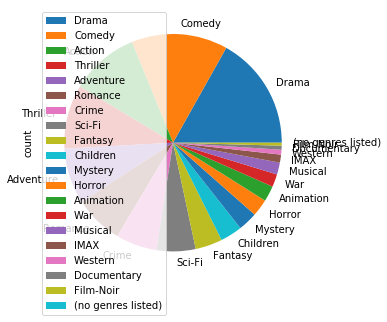

In [2]:
df_movie=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movies.csv", encoding = "ISO-8859-1")
df_ratings=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movie_ratings.csv",encoding = "ISO-8859-1")
df_earnings=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movies_gross_earnings_2013.csv",encoding = "ISO-8859-1",usecols=['imdb','title','domgross_2013$','intgross_2013$'])

df_earnings=df_earnings.rename(columns={'domgross_2013$':'us_gross','intgross_2013$':'international_gross'})
df_earnings['title']=df_earnings['title'].str.replace("&amp;","&")
df_earnings['title']=df_earnings['title'].str.replace("&#39;",",")
df_earnings.set_index('imdb')

#print(df_earnings.head())
#print(df_movie.shape)
#print(df_movie.columns)
#print(df_movie.head())
#print(df_ratings.head())

df=df_movie.merge(df_ratings,on="movieId", how="left") 
df.set_index("movieId")

listCategories=[]
for row in df['genres']:
    categories=row.split('|')
    for category in categories:
        if (category in listCategories)==False:
            listCategories.append(category) 
 

for category in listCategories:
        mask=df["genres"].str.contains(category)
        df[category]=0
        df[category][mask]=1
        #print(mask)

    
listCategoryCount=[]

for column in listCategories:
    listCategoryCount.append({'column':column, 'count':df[column].sum()})
    
dfCategory=pd.DataFrame(listCategoryCount,index=listCategories)

dfCategory=dfCategory.sort_values(by="count",ascending=False)
dfCategory.plot.pie(y='count', figsize=(5, 5))

print(dfCategory['count'].head(10))
print("missing genres",df['genres'].isnull().sum())

mask=df['rating']>=2.5
df['liked']=0
df.loc[mask,'liked']=1


In [3]:
listRating=df.groupby(['movieId'])['rating'].mean()
listUserCount=df.groupby(['movieId'])['userId'].count()
listMovieId=df.groupby(['movieId'])['movieId'].unique()
listMovieTitle=df.groupby(['movieId'])['title'].unique()
listLiked =df.groupby(['movieId'])['liked'].sum()

dfPopularity=pd.DataFrame(columns=['movieId'])
dfPopularity.set_index('movieId')

for item in listMovieId:
    movieId=item[0]
    item_to_append=[movieId]
    #item_to_append=pd.Series([movieId,0,0], index = dfPopularity.columns)
    #print(item_to_append)
    #dfPopularity.append(item_to_append,ignore_index=True)
    dfPopularity.loc[len(dfPopularity)]=item_to_append


dfRating=pd.DataFrame(listRating)
dfPopularity=dfPopularity.merge(dfRating, on='movieId',how="left", left_index=True,right_index=True)

dfTitle=pd.DataFrame(listMovieTitle)
dfPopularity=dfPopularity.merge(dfTitle, on='movieId',how="left", left_index=True,right_index=True)

dfUserCount=pd.DataFrame(listUserCount)
dfPopularity=dfPopularity.merge(dfUserCount, on='movieId',how="left", left_index=True,right_index=True)

dfPopularity=dfPopularity.rename(columns={'userId':'user_count'})

dfLiked=pd.DataFrame(listLiked)
dfPopularity=dfPopularity.merge(dfLiked, on='movieId',how="left", left_index=True,right_index=True)

print(dfPopularity.head())

#dfPopularity=pd.DataFrame({'rating':listRating,'count':listUserCount},index=listMovieId)

  movieId    rating                                 title  user_count  liked
0       1  3.872470                    [Toy Story (1995)]         247    227
1       2  3.401869                      [Jumanji (1995)]         107     94
2       3  3.161017             [Grumpier Old Men (1995)]          59     44
3       4  2.384615            [Waiting to Exhale (1995)]          13      8
4       5  3.267857  [Father of the Bride Part II (1995)]          56     48


     movieId    rating                                              title  \
284      318  4.487138                 [Shawshank Redemption, The (1994)]   
48        50  4.370647                       [Usual Suspects, The (1995)]   
472      527  4.303279                          [Schindler's List (1993)]   
535      608  4.256696                                     [Fargo (1996)]   
266      296  4.256173                              [Pulp Fiction (1994)]   
2288    2858  4.236364                           [American Beauty (1999)]   
953     1196  4.232906  [Star Wars: Episode V - The Empire Strikes Bac...   
232      260  4.221649        [Star Wars: Episode IV - A New Hope (1977)]   
955     1198  4.193182  [Raiders of the Lost Ark (Indiana Jones and th...   
2062    2571  4.183398                               [Matrix, The (1999)]   

      user_count  liked  
284          311    307  
48           201    198  
472          244    235  
535          224    212  
266          324    31

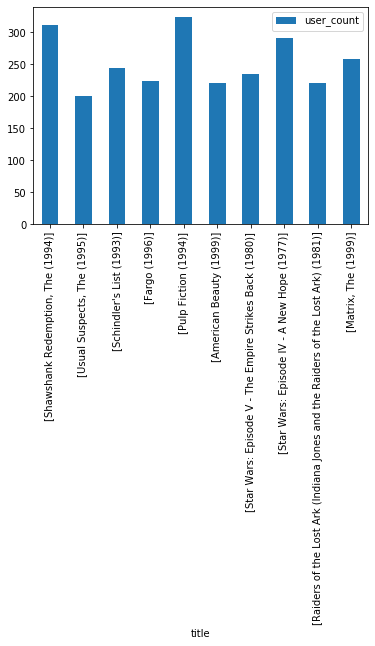

In [4]:
top10=dfPopularity[dfPopularity['user_count']>200].sort_values('rating',ascending=False).head(10)
print(top10)
top10.plot.bar(x="title",y='user_count')

     movieId    rating                                              title  \
284      318  4.487138                 [Shawshank Redemption, The (1994)]   
48        50  4.370647                       [Usual Suspects, The (1995)]   
472      527  4.303279                          [Schindler's List (1993)]   
535      608  4.256696                                     [Fargo (1996)]   
266      296  4.256173                              [Pulp Fiction (1994)]   
2288    2858  4.236364                           [American Beauty (1999)]   
953     1196  4.232906  [Star Wars: Episode V - The Empire Strikes Bac...   
232      260  4.221649        [Star Wars: Episode IV - A New Hope (1977)]   
955     1198  4.193182  [Raiders of the Lost Ark (Indiana Jones and th...   
2062    2571  4.183398                               [Matrix, The (1999)]   

      user_count  liked  popularity  
284          311    307   98.713826  
48           201    198   98.507463  
472          244    235   96.311475  


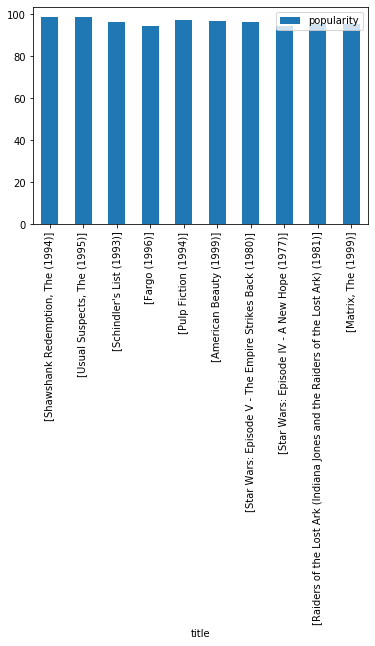

In [5]:
dfPopularity['popularity']= dfPopularity['liked']/dfPopularity['user_count']*100

#print(dfPopularity[['movieId','title','liked','user_count','popularity']])

top10=dfPopularity[(dfPopularity['popularity']>50) & (dfPopularity['user_count']>200) ].sort_values('rating',ascending=False).head(10)
print(top10)
top10.plot.bar(x="title",y='popularity')

In [6]:
def strMerge (df_search,common_column,searchFor):
        result=df_search[df_search[common_column].str.contains(searchFor)==True]
        return result

def is_empty(any_structure):
    if any_structure:
        return False
    else:
        return True
    
def Sort_Tuple(tup):  
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
          
        for j in range(0, lst-i-1):  
            if (tup[j][1] > tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup      
    
#print(strMerge(df_earnings,'title',"Toy Story",'imdb'))    
    
#dfPopularity.apply(lambda x: result=strMerge(df_earnings,'title',x['title'],axis=1)

#print(df_earnings.head())

createPopularity=False

if createPopularity==True:
    dfPopularity['us_gross']=0.0
    dfPopularity['international_gross']=0.0
    dfPopularity['imdb']=''


    for i in dfPopularity.index: 
        title=dfPopularity['title'][i][0]
        #print("title:",title)
        matches=process.extract(title,df_earnings['title'],limit=df_earnings.shape[0])
        highest_tuple=tuple()
        for potential_match in matches:
            if potential_match[1]>=92:
                print("matches:", potential_match)
                if is_empty(highest_tuple):
                    highest_tuple=potential_match
                if potential_match[1]>= highest_tuple[1]:
                    highest_tuple=potential_match
            #print(type(potential_match))
            #print(row)
            #print(dfPopularity.loc[dfPopularity['title']==potential_match[0],'found'])
        if is_empty(highest_tuple)==False:
            row=df_earnings.loc[df_earnings['title']==highest_tuple[0]].iloc[0]
            #print(row)
            us_gross=row['us_gross'].astype(float)
            international_gross=row['international_gross'].astype(float)
            imdb=row['imdb']
            dfPopularity['us_gross'][i]=us_gross
            dfPopularity['international_gross'][i]=international_gross
            dfPopularity['imdb'][i]=imdb

    print(dfPopularity.head())
    dfPopularity.to_csv('movie_popularity.csv',index=True,index_label="movieId")



matches: ('The American President', 95, 1515)
matches: ('Sense and Sensibility', 95, 1511)
matches: ('Mortal Kombat', 95, 1504)
matches: ('The Usual Suspects', 95, 1520)
matches: ('Home for the holidays', 95, 1501)
matches: ('Eye for an Eye', 95, 1454)
matches: ('From Dusk Till Dawn', 95, 1457)
matches: ('The Bridges of Madison County', 95, 1516)
matches: ('Man of the Year', 95, 771)
matches: ('Batman Forever', 95, 1491)
matches: ('Die Hard: With a Vengeance', 95, 1499)
matches: ('Before Sunrise', 95, 1492)
matches: ('Legends of the Fall', 95, 1532)
matches: ('Man of the House', 95, 871)
matches: ('The Quick and the Dead', 95, 1519)
matches: ('The Santa Clause', 95, 1545)
matches: ('The Shawshank Redemption', 95, 1547)
matches: ('Ace Ventura: Pet Detective', 95, 1525)
matches: ('Naked Gun 33 1/3: The Final Insult', 95, 1534)
matches: ('Street Fighter', 95, 1540)
matches: ('The Age of Innocence', 95, 1562)
matches: ('Beverly Hills Cop III', 95, 1526)
matches: ('Dazed and Confused', 95, 

matches: ('Muppets From Space', 95, 1306)
matches: ('The Blair Witch Project', 95, 1319)
matches: ('Eyes Wide Shut', 95, 1297)
matches: ('Drop Dead Gorgeous', 95, 1295)
matches: ('The Color Purple', 95, 1681)
matches: ('Little Shop of Horrors', 95, 1666)
matches: ('The Sixth Sense', 95, 1326)
matches: ('The 13th Warrior', 95, 1318)
matches: ('American Beauty', 95, 1280)
matches: ('For Love of the Game', 95, 1300)
matches: ('Boys Don,t Cry', 95, 1289)
matches: ('High Plains Drifter', 95, 1781)
matches: ('Days of Heaven', 95, 1747)
matches: ('Home Alone 2: Lost in New York', 95, 1578)
matches: ('Three to Tango', 95, 1328)
matches: ('Who Framed Roger Rabbit', 95, 1646)
matches: ('Licence to Kill', 95, 1621)
matches: ('Being John Malkovich', 95, 1286)
matches: ('Anywhere But Here', 95, 1284)
matches: ('Sleepy Hollow', 95, 1313)
matches: ('Fatal Attraction', 95, 1650)
matches: ('Anna and the King', 95, 1283)
matches: ('Stuart Little', 95, 1316)
matches: ('The Talented Mr. Ripley', 95, 1327)

matches: ('Scary Movie 3', 95, 1046)
matches: ('The Italian Job', 95, 1056)
matches: ('Shattered Glass', 95, 1049)
matches: ('The Matrix Revolutions', 95, 1062)
matches: ('Love Actually', 95, 1037)
matches: ('Master and Commander: The Far Side of the World', 95, 1038)
matches: ('The Hunchback of Notre Dame', 95, 1481)
matches: ('The Last Samurai', 95, 1058)
matches: ('Something,s Gotta Give', 95, 1051)
matches: ('Girl with a Pearl Earring', 95, 1022)
matches: ('The Lord of the Rings: The Return of the King', 95, 1060)
matches: ('Mona Lisa Smile', 95, 1039)
matches: ('House of Sand and Fog', 95, 1026)
matches: ('Cold Mountain', 95, 1013)
matches: ('The Great Gatsby', 95, 74)
matches: ('The Butterfly Effect', 95, 988)
matches: ('50 First Dates', 95, 928)
matches: ('Secret Window', 95, 977)
matches: ('Dawn of the Dead', 95, 945)
matches: ('Dawn of the Dead', 95, 1746)
matches: ('Eternal Sunshine of the Spotless Mind', 95, 948)
matches: ('Home on the Range', 95, 956)
matches: ('Ella Enchan

matches: ('We Own the Night', 95, 734)
matches: ('Michael Clayton', 95, 699)
matches: ('Lars and the real Girl', 95, 697)
matches: ('30 Days of Night', 95, 667)
matches: ('Gone Baby Gone', 95, 684)
matches: ('No Country for Old Men', 95, 701)
matches: ('Be Kind Rewind', 95, 566)
matches: ('The Man from Earth', 95, 721)
matches: ('Southland Tales', 95, 794)
matches: ('The Golden Compass', 95, 719)
matches: ('The Bucket List', 95, 718)
matches: ('The Kite Runner', 95, 720)
matches: ('Wristcutters: A Love Story', 95, 821)
matches: ('There Will Be Blood', 95, 729)
matches: ('Charlie Wilson,s War', 95, 677)
matches: ('Definitely, Maybe', 95, 578)
matches: ('The Other Boleyn Girl', 95, 642)
matches: ('The Dark Knight', 95, 634)
matches: ('Forgetting Sarah Marshall', 95, 585)
matches: ('The Forbidden Kingdom', 95, 637)
matches: ('Made of Honor', 95, 605)
matches: ('Stargate: The Ark of Truth', 95, 625)
matches: ('What Happens In Vegas', 95, 661)
matches: ('The Chronicles of Narnia: Prince Cas

matches: ('Another Earth', 95, 190)
matches: ('Tinker Tailor Soldier Spy', 95, 297)
matches: ('A Dangerous Method', 95, 187)
matches: ('Martha Marcy May Marlene', 95, 244)
matches: ('The Three Musketeers', 95, 293)
matches: ('Paranormal Activity 3', 95, 254)
matches: ('Paranormal Activity', 95, 703)
matches: ('Johnny English Reborn', 95, 232)
matches: ('What,s Your Number', 95, 304)
matches: ('Puss in Boots', 95, 258)
matches: ('The Adventures of Tintin', 95, 275)
matches: ('The Twilight Saga: Breaking Dawn - Part 1', 95, 295)
matches: ('The Twilight Saga: Breaking Dawn - Part 2', 92, 170)
matches: ('Arthur Christmas', 95, 192)
matches: ('Bullet to the Head', 95, 109)
matches: ('The Expendables 2', 95, 161)
matches: ('The Hunger Games', 95, 164)
matches: ('The Dark Knight Rises', 95, 158)
matches: ('New Year,s Eve', 95, 250)
matches: ('Mission: Impossible - Ghost Protocol', 95, 247)
matches: ('We Bought a Zoo', 95, 302)
matches: ('The Girl with the Dragon Tattoo', 95, 282)
matches: ('T

In [7]:
if createPopularity==True:
    dfPopularity=pd.read_csv("movie_popularity.csv",encoding = "ISO-8859-1")
else:
    dfPopularity=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movie_popularity.csv",encoding = "ISO-8859-1")

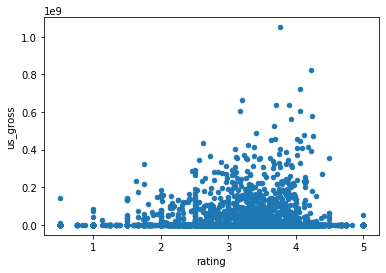

In [8]:
dfPopularity.plot(kind="scatter", x="rating", y="us_gross")

In [10]:
filter=(dfPopularity['popularity']>50) & (dfPopularity['user_count']>10) & (dfPopularity['us_gross']>200000000)
dfPopularity=dfPopularity.sort_values(by=['us_gross'],ascending=[False])
for index, row in dfPopularity[filter].iterrows(): print(row['title'],"${:,.0f}".format(row['us_gross']))



['E.T. the Extra-Terrestrial (1982)'] $1,050,038,377
['Star Wars: Episode V - The Empire Strikes Back (1980)'] $820,821,721
['Star Wars: Episode VI - Return of the Jedi (1983)'] $723,340,482
['Star Wars: Episode I - The Phantom Menace (1999)'] $663,632,711
['Jurassic Park (1993)'] $638,063,379
['Close Encounters of the Third Kind (1977)'] $637,962,288
['Rocky Horror Picture Show, The (1975)'] $605,399,166
['American Graffiti (1973)'] $603,047,833
['Dark Knight, The (2008)'] $577,216,380
['Blazing Saddles (1974)'] $564,485,269
['Beverly Hills Cop (1984)'] $526,202,467
["Pirates of the Caribbean: Dead Man's Chest (2006)"] $489,266,869
['Lord of the Rings: The Return of the King, The (2003)'] $478,385,772
["One Flew Over the Cuckoo's Nest (1975)"] $471,681,892
['Back to the Future (1985)'] $455,981,879
['Dark Knight Rises, The (2012)'] $454,699,213
['Star Wars: Episode III - Revenge of the Sith (2005)'] $453,675,396
['Lord of the Rings: The Two Towers, The (2002)'] $443,662,324
['Transfor

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
